In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import sklearn
import re

sns.set(font='helvetica', context='talk', font_scale=1., style='white')

# Runwise decoding

## pars

In [2]:
reg = re.compile('.*/sub-(?P<subject>[0-9]+)_mask-.')


In [3]:
pars_ = glob.glob('/data/risk_precision/ds-numrisk/derivatives/decoding_runwise_smoothed/sub-*/func/sub-*_mask-NPC1_*_desc-decodepars.pkl')

pars = []

for p_ in pars_:
    p = pd.read_pickle(p_)
    meta = reg.match(p_).groupdict()


    pars.append(p)
    

    
pars = pd.concat(pars)

## PDF

In [4]:
reg = re.compile('.*/sub-(?P<subject>[0-9]+)_mask-.')


In [5]:
# stimulus_range = np.geomspace(1, 50, 200)

In [6]:
pdf_ = glob.glob('/data/risk_precision/ds-numrisk/derivatives/decoding_runwise_smoothed/sub-*/func/sub-*_mask-NPC1_*_desc-decodepdfs.pkl')

pdf = []

for p_ in pdf_:
    p = pd.read_pickle(p_)
    
#     if p['pdf'].columns[-1] > np.log(51):
    
    p1, p2 = p['pdf'], p['pars']
#     p1.columns = pd.Index(stimulus_range, name='stimulus')
    p1.columns = np.round(np.exp(p['pdf'].columns.astype(float)), 3)
    p = pd.concat((p1, p2), keys=['pdf', 'pars'], axis=1)
    p['subject'] = int(reg.match(p_).group(1))
    p['run'] = np.repeat(range(1, 7), len(p) // 6)

    pdf.append(p.set_index(['subject', 'run'], append=True))
    

    
pdf = pd.concat(pdf)

pdf[('pars', 'stimulus')] = pdf.index.get_level_values('stimulus')
pdf = pdf.reorder_levels(['subject', 'run', 'mask', 'stimulus', 'log(stimulus)'])

In [7]:
import scipy as sp

In [8]:
interp = sp.interpolate.interp1d(pdf['pdf'].columns.values, pdf['pdf'], fill_value='extrapolate')
new_x = np.linspace(1, 28, 500)
pdf_new = pd.DataFrame(interp(new_x), columns=pd.Series(new_x, name='stimulus'), index=pdf['pdf'].index).astype(np.float)

In [9]:
stimulus_range_cols = pdf_new.columns[np.argmin((pdf_new.columns.values[:, np.newaxis] - np.array([5, 7, 10, 14, 20, 28])[np.newaxis, :])**2, 0)]

In [10]:
stimulus_range_cols = pdf['pdf'].columns[np.argmin((pdf['pdf'].columns.values[:, np.newaxis] - np.array([5, 7, 10, 14, 20, 28])[np.newaxis, :])**2, 0)]
pdf[('pars', 'argmax_num')] = np.round(pdf['pdf'][stimulus_range_cols].idxmax(1), 0).astype(int)

In [11]:
pdf[('pars', 'correct_argmax')] = pdf[('pars', 'argmax_num')] == pdf[('pars', 'stimulus')]

In [12]:
import matplotlib.pyplot as plt

/Users/gdehol/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


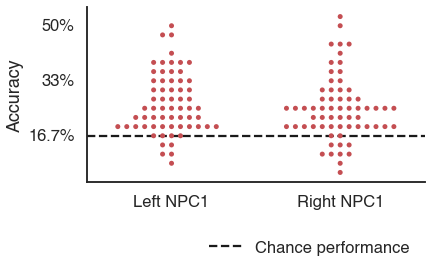

In [13]:
tmp = pdf.copy()['pars'].drop('stimulus', 1).reset_index()
subjectwise_accuracy = tmp.groupby(['subject', 'mask']).mean()[['correct_argmax']].reset_index()

subjectwise_accuracy['mask'] = subjectwise_accuracy['mask'].map({'NPC1_L':'Left NPC1', 'NPC1_R':'Right NPC1'})

fac = sns.catplot('mask', 'correct_argmax', data=subjectwise_accuracy.reset_index(), color=sns.color_palette()[3], kind='swarm',
                  size=4)

fac.set(ylabel='Accuracy')
fac.set(xlabel=None)

plt.axhline(1/ len(stimulus_range_cols), c='k', ls='--', label='Chance performance')
sns.despine()

plt.yticks([1/6., 2/6., 3/6.], ['16.7%', '33%', '50%'], va='center')

plt.gcf().set_size_inches(7, 3.5)

plt.legend(bbox_to_anchor=(1,-.5), loc="lower right", frameon=False)
plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/figures/theory/decoding_accuracyplot.svg', transparent=True)

In [14]:
def plot_confusion(data, *args, **kwargs):
    tmp = data
#     tmp['stimulus_'] = tmp.index.get_level_values('stimulus')
    tmp = tmp.pivot_table(index='stimulus', columns='argmax_num', values='lower', aggfunc='count')
    tmp /= tmp.sum(0)
    sns.heatmap(tmp.iloc[::-1, :], cbar=False, vmin=0, vmax=0.35)

    

In [15]:
import matplotlib as mpl

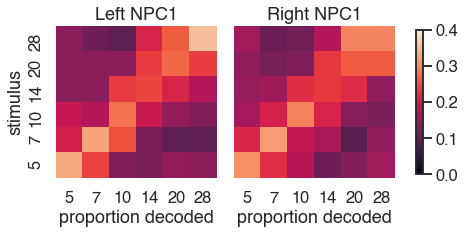

In [16]:
tmp = pdf.copy()['pars'].droplevel('stimulus', 0).reset_index()
tmp['mask'] = tmp['mask'].map({'NPC1_L':'Left NPC1', 'NPC1_R':'Right NPC1'})
tmp.index.set_names('index', inplace=True)
tmp.columns.set_names(None, inplace=True)

tmp = pdf.copy()['pars'].droplevel('stimulus').reset_index()
tmp.columns.set_names(None, inplace=True)
tmp['mask'] = tmp['mask'].map({'NPC1_L':'Left NPC1', 'NPC1_R':'Right NPC1'})


fac = sns.FacetGrid(tmp, col='mask', col_wrap=3)

fac.map_dataframe(plot_confusion)
fac.set_xlabels('proportion decoded')
fac.set_ylabels('stimulus')
fac.set_titles('{col_name}')

fig = fac.fig
cmap = 'rocket'
norm = mpl.colors.Normalize(vmin=0, vmax=.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar = fig.colorbar(sm, ax=fac.axes.ravel().tolist(), shrink=0.95)

plt.gcf().set_size_inches(10, 3.5)

plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/figures/theory/confusion_matrix.svg', transparent=True)

In [17]:
import pingouin

In [18]:
interp = sp.interpolate.interp1d(pdf['pdf'].columns.values, pdf['pdf'], fill_value='extrapolate')
new_x = np.linspace(1, 28, 500)
pdf_new = pd.DataFrame(interp(new_x), columns=pd.Series(new_x, name='stimulus'), index=pdf['pdf'].index)

In [19]:
pdf[('pars', 'E[stimulus]')] = (pdf_new.columns.astype(float) * pdf_new).sum(1) / pdf_new.sum(1)
pdf[('pars', 'sd')] = np.sqrt((((pdf[('pars', 'E[stimulus]')].values[:, np.newaxis] - pdf_new.columns.values)**2) * pdf_new).sum(1) / pdf_new.sum(1))

In [20]:
subjectwise_r = pdf['pars'].groupby(['subject', 'mask']).apply(lambda d: pingouin.corr(d['E[stimulus]'], d.index.get_level_values('stimulus')))

In [21]:
subjectwise_r.unstack('mask')['r'].mean()

mask
NPC1      0.207391
NPC1_L    0.275391
NPC1_R    0.273813
dtype: float64

In [22]:
tmp = subjectwise_r.unstack('mask')['r']
tmp.isnull().sum()

mask
NPC1      0
NPC1_L    0
NPC1_R    0
dtype: int64

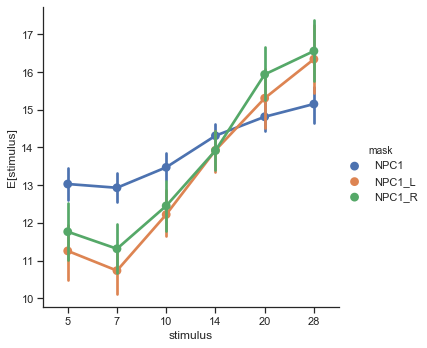

In [23]:
sns.catplot('stimulus', 'E[stimulus]', 'mask', 
            data=pdf['pars'].drop('stimulus', 1).groupby(['subject', 'mask', 'stimulus']).mean().reset_index(), kind='point')

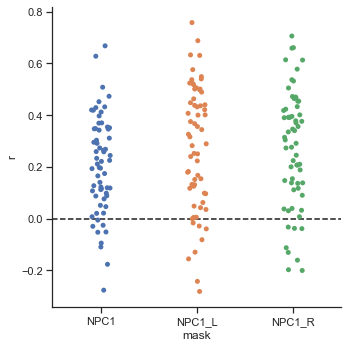

In [24]:

sns.catplot('mask', 'r', data=subjectwise_r.reset_index())
plt.axhline(0, c='k', ls='--')

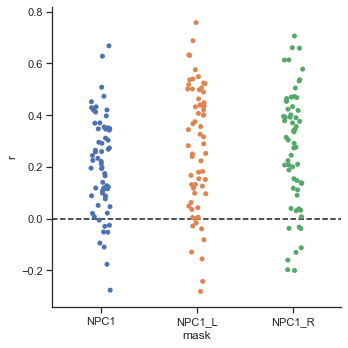

In [25]:

sns.catplot('mask', 'r', data=subjectwise_r.reset_index())
plt.axhline(0, c='k', ls='--')

In [26]:
# def plot_paradigm(data, *args, **kwargs):
def plot_paradigm(data, palette=None, *args, **kwargs):
    palette = sns.color_palette(palette)
    stimulus = data.index.get_level_values('stimulus')
    t = range(len(data))
    plt.plot(t, data.index.get_level_values('stimulus'), color=palette[0], lw=2, ls='--')
    plt.plot(t, data['E[stimulus]'], color=palette[1], lw=2)
#     plt.fill_between(t, np.exp(data['lower']), np.exp(data['upper']), alpha=0.2, color=palette[1])
    plt.fill_between(t, data['E[stimulus]'] - data.sd, data['E[stimulus]'] + data.sd, alpha=0.2, color=palette[1])

In [27]:
sns.set_context('talk')

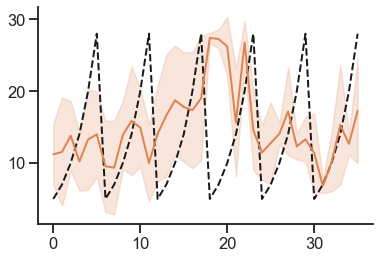

In [28]:
d = pdf.loc[(34, slice(None), 'NPC1'), 'pars']

plot_paradigm(d, palette=['k', sns.color_palette()[1]])
sns.despine()

In [29]:
subjectwise_r_runwise = subjectwise_r['r']
subjectwise_sd_runwise = pdf[('pars', 'sd')].groupby(['subject', 'mask']).mean()

# Trialwise 

In [822]:
pdf_ = glob.glob('/data/risk_precision/ds-numrisk/derivatives/decoding_trialwise_smoothed/sub-*/func/sub-*_mask-NPC1*_desc-decodepdfs.pkl')

pdf = []

for p_ in pdf_:
    p = pd.read_pickle(p_)
        
        
    # Make sure we have the new version
#     if p['pdf'].columns[-1] > np.log(51):
    
    p1, p2 = p['pdf'], p['pars']
#     p1.columns = pd.Index(stimulus_range, name='stimulus')
    p1.columns = np.round(np.exp(p['pdf'].columns.astype(float)), 3)
    p = pd.concat((p1, p2), keys=['pdf', 'pars'], axis=1)
    p['subject'] = int(reg.match(p_).group(1))
    p['run'] = np.repeat(range(1, 7), len(p) // 6)

    pdf.append(p.set_index(['subject', 'run'], append=True))


    
pdf = pd.concat(pdf)

pdf[('pars', 'stimulus')] = pdf.index.get_level_values('stimulus')
pdf = pdf.reorder_levels(['subject', 'run', 'mask', 'stimulus', 'log(stimulus)'])

In [823]:
stimulus_range_cols = pdf['pdf'].columns[np.argmin((pdf['pdf'].columns.values[:, np.newaxis] - np.array([5, 7, 10, 14, 20, 28])[np.newaxis, :])**2, 0)]
pdf[('pars', 'argmax_num')] = np.round(pdf['pdf'][stimulus_range_cols].idxmax(1), 0).astype(int)

In [828]:
pdf.loc[(1, slice(None), 'NPC1'), :]

pdf                              \
stimulus                                 1.0 1.02 1.04 1.061 1.082 1.103   
subject run mask stimulus log(stimulus)                                    
1       1   NPC1 5        1.609438       0.0  0.0  0.0   0.0   0.0   0.0   
                          1.609438       0.0  0.0  0.0   0.0   0.0   0.0   
                          1.609438       0.0  0.0  0.0   0.0   0.0   0.0   
                          1.609438       0.0  0.0  0.0   0.0   0.0   0.0   
                          1.609438       0.0  0.0  0.0   0.0   0.0   0.0   
...                                      ...  ...  ...   ...   ...   ...   
        6   NPC1 28       3.332205       0.0  0.0  0.0   0.0   0.0   0.0   
                          3.332205       0.0  0.0  0.0   0.0   0.0   0.0   
                          3.332205       0.0  0.0  0.0   0.0   0.0   0.0   
                          3.332205       0.0  0.0  0.0   0.0   0.0   0.0   
                          3.332205       0.0  0.0  0.0   0.0   0.0   0.0   

                                                                ...         \
stimulus                                1.125 1.148 1.17 1.194  ... 48.072   
subject run mask stimulus log(stimulus)                         ...          
1       1   NPC1 5        1.609438        0.0   0.0  0.0   0.0  ...    0.0   
                          1.609438        0.0   0.0  0.0   0.0  ...    0.0   
                          1.609438        0.0   0.0  0.0   0.0  ...    0.0   
                          1.609438        0.0   0.0  0.0   0.0  ...    0.0   
                          1.609438        0.0   0.0  0.0   0.0  ...    0.0   
...                                       ...   ...  ...   ...  ...    ...   
        6   NPC1 28       3.332205        0.0   0.0  0.0   0.0  ...    0.0   
                          3.332205        0.0   0.0  0.0   0.0  ...    0.0   
                          3.332205        0.0   0.0  0.0   0.0  ...    0.0   
                          3.332205        0.0   0.0  0.0   0.0  ...    0.0   
                          3.332205        0.0   0.0  0.0   0.0  ...    0.0   

                                                          pars            \
stimulus                                49.027 50.0        map  log(map)   
subject run mask stimulus log(stimulus)                                    
1       1   NPC1 5        1.609438         0.0  0.0  23.688828  3.165004   
                          1.609438         0.0  0.0  28.273619  3.341929   
                          1.609438         0.0  0.0   6.865603  1.926524   
                          1.609438         0.0  0.0  23.688828  3.165004   
                          1.609438         0.0  0.0  21.471176  3.066711   
...                                        ...  ...        ...       ...   
        6   NPC1 28       3.332205         0.0  0.0   4.915193  1.592331   
                          3.332205         0.0  0.0  24.638750  3.204320   
                          3.332205         0.0  0.0   5.112292  1.631648   
                          3.332205         0.0  0.0  19.461138  2.968420   
                          3.332205         0.0  0.0   4.819511  1.572673   

                                                                       \
stimulus                                       sd     lower     upper   
subject run mask stimulus log(stimulus)                                 
1       1   NPC1 5        1.609438       0.073749  3.007736  3.282954   
                          1.609438       0.020674  3.302612  3.361588   
                          1.609438       0.014259  1.906865  1.946182   
                          1.609438       0.086597  2.988078  3.282954   
                          1.609438       0.074878  2.988078  3.243637   
...                                           ...       ...       ...   
        6   NPC1 28       3.332205       0.019349  1.553014  1.611989   
                          3.332205       0.065913  3.086370  3.341929   
               

In [846]:
p = pd.read_pickle('/Users/gdehol/Downloads/sub-1_mask-NPC1_n_voxels-500_desc-decodepdfs.pkl')['pdf']
p.columns = np.round(np.exp(p.columns.astype(float)), 3)
p  /= p.sum(1).values[:, np.newaxis]

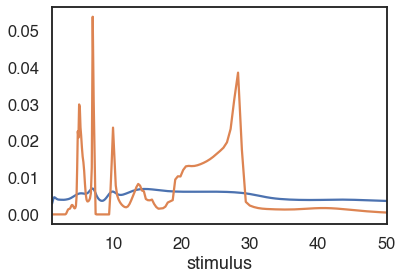

In [854]:
p.mean().plot()
p2 = pdf.loc[(1, slice(None), 'NPC1'), 'pdf']
p2 = p2 / p2.sum(1).values[:, np.newaxis]
p2.mean().plot()

In [694]:
def plot_confusion(data, *args, **kwargs):
    tmp = data
#     tmp['stimulus_'] = tmp.index.get_level_values('stimulus')
    tmp = tmp.pivot_table(index='stimulus', columns='argmax_num', values='lower', aggfunc='count')
    tmp /= tmp.sum(0)
    sns.heatmap(tmp.iloc[::-1, :], cbar=False, vmin=0, vmax=0.35)

pdf[('pars', 'correct_argmax')] = pdf[('pars', 'argmax_num')] == pdf[('pars', 'stimulus')]

In [695]:
import matplotlib as mpl
import matplotlib.pyplot as plt

/Users/gdehol/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


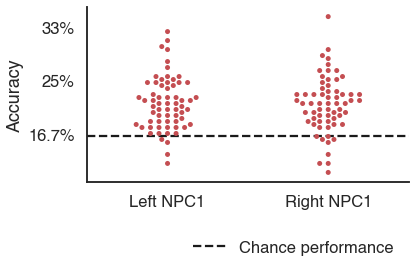

In [696]:
tmp = pdf.copy()['pars'].drop('stimulus', 1).reset_index()
subjectwise_accuracy = tmp.groupby(['subject', 'mask']).mean()[['correct_argmax']].reset_index()

subjectwise_accuracy['mask'] = subjectwise_accuracy['mask'].map({'NPC1_L':'Left NPC1', 'NPC1_R':'Right NPC1'})

fac = sns.catplot('mask', 'correct_argmax', 
                  data=subjectwise_accuracy.reset_index(), color=sns.color_palette()[3], kind='swarm',
                  dodge=True,
                  size=4)

fac.set(ylabel='Accuracy')
fac.set(xlabel=None)

plt.axhline(1/ len(stimulus_range_cols), c='k', ls='--', label='Chance performance')
sns.despine()

plt.yticks([1/6., 1/4., 1/3.], ['16.7%', '25%', '33%'], va='center')

plt.gcf().set_size_inches(7, 3.5)

plt.legend(bbox_to_anchor=(1,-.5), loc="lower right", frameon=False)

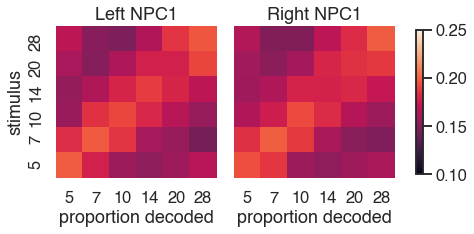

In [697]:
tmp = pdf.copy()['pars'].droplevel('stimulus').reset_index()
tmp.columns.set_names(None, inplace=True)
tmp['mask'] = tmp['mask'].map({'NPC1_L':'Left NPC1', 'NPC1_R':'Right NPC1'})


fac = sns.FacetGrid(tmp, col='mask', col_wrap=3)

fac.map_dataframe(plot_confusion)
fac.set_xlabels('proportion decoded')
fac.set_ylabels('stimulus')
fac.set_titles('{col_name}')

fig = fac.fig
cmap = 'rocket'
norm = mpl.colors.Normalize(vmin=.1, vmax=.25)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar = fig.colorbar(sm, ax=fac.axes.ravel().tolist(), shrink=0.95)

plt.gcf().set_size_inches(10, 3.5)

Go to regularly, linearly-gridded x

array([[ 9.971738 ],
       [ 2.4120345],
       [ 1.5961508],
       ...,
       [19.91755  ],
       [14.754239 ],
       [14.284998 ]], dtype=float32)

In [767]:
pdf[('pdf')] = (pdf[('pdf')] / pdf['pdf'].sum(1).values[:, np.newaxis])

In [772]:
interp = sp.interpolate.interp1d(pdf['pdf'].columns.values, pdf['pdf'], fill_value='extrapolate')
new_x = np.linspace(1, 28, 500)

pdf_new = pd.DataFrame(interp(new_x), columns=pd.Series(new_x, name='stimulus'), index=pdf['pdf'].index)

In [773]:
pdf[('pars', 'E[stimulus]')] = (pdf_new.columns.astype(float) * pdf_new).sum(1) / pdf_new.sum(1)
pdf[('pars', 'sd')] = np.sqrt((((pdf[('pars', 'E[stimulus]')].values[:, np.newaxis] - pdf_new.columns.values)**2) * pdf_new).sum(1) / pdf_new.sum(1))

In [774]:
import scipy as sp

In [775]:
import pingouin
subjectwise_r = pdf['pars'].groupby(['subject', 'mask']).apply(lambda d: pingouin.corr(d['E[stimulus]'], d.index.get_level_values('stimulus')))

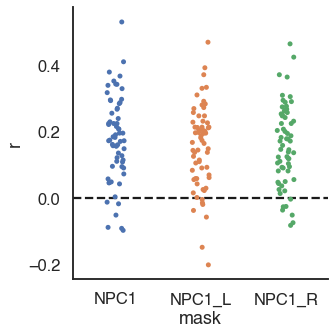

In [776]:

sns.catplot('mask', 'r', data=subjectwise_r.reset_index())
plt.axhline(0, c='k', ls='--')

(0, 28)

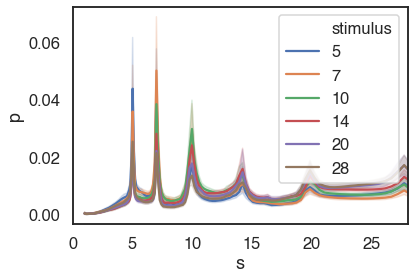

In [777]:
p = pdf.groupby(['subject', 'stimulus']).mean()['pdf'].stack().to_frame('p')
p.index.names = ['subject', 'stimulus', 's']

sns.lineplot('s', 'p', 'stimulus', data=p.reset_index(), palette=sns.color_palette()[:6])
plt.xlim(0, 28)

In [778]:
subjectwise_r[['r']].unstack('mask').to_csv('/data/risk_precision/ds-numrisk/derivatives/subjectwise_r.tsv', sep='\t')

In [779]:
subjectwise_r_trialwise = subjectwise_r['r']
subjectwise_sd_trialwise = pdf[('pars', 'sd')].groupby(['subject', 'mask']).mean()

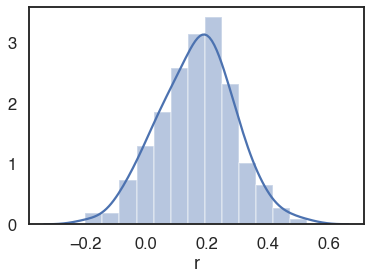

In [780]:
sns.distplot(subjectwise_r_trialwise)

In [781]:
subjectwise_r_runwise

subject  mask           
1        NPC1    pearson    0.273
         NPC1_L  pearson    0.448
         NPC1_R  pearson    0.433
2        NPC1    pearson    0.342
         NPC1_L  pearson    0.631
                            ...  
63       NPC1_L  pearson    0.282
         NPC1_R  pearson    0.273
64       NPC1    pearson    0.264
         NPC1_L  pearson    0.421
         NPC1_R  pearson    0.395
Name: r, Length: 192, dtype: float64

In [782]:
tmp = pd.concat((subjectwise_r_runwise.droplevel(-1), subjectwise_r_trialwise.droplevel(-1), subjectwise_sd_runwise, subjectwise_sd_trialwise,
           ), keys=[('r', 'run'), ('r', 'trial'), ('sd',' run'), ('sd', 'trial')],
          names=['type', 'unit'])

tmp= tmp.unstack(['type', 'unit', 'mask'])
# tmp.to_csv('/data/risk_precision/ds-numrisk/derivatives/subjectwise_decoding_pars.tsv', sep='\t')

In [783]:
tmp.loc[30:40]

type         r                                           sd            \
unit       run                trial                     run             
mask      NPC1 NPC1_L NPC1_R   NPC1 NPC1_L NPC1_R      NPC1    NPC1_L   
subject                                                                 
30       0.098 -0.243 -0.131  0.343  0.168  0.082  5.786151  4.675284   
31       0.351  0.154  0.578  0.296  0.212  0.275  6.056997  2.152100   
32      -0.095  0.401  0.138  0.222  0.165  0.139  6.096862  0.544647   
33      -0.053  0.125  0.224  0.173  0.149  0.208  7.113357  1.506871   
34       0.051  0.436  0.207  0.225  0.214  0.082  5.234405  0.778889   
35       0.354  0.367  0.335  0.161  0.093  0.147  6.125952  4.566412   
36       0.348  0.131 -0.038  0.158  0.002  0.146  5.975439  5.297097   
37       0.419  0.633  0.532  0.183  0.195  0.201  5.212101  0.700746   
38       0.291  0.438  0.706  0.340  0.281  0.266  6.014080  0.445996   
39       0.628  0.250  0.390  0.368  0.232  0.254  6.659433  1.421570   
40       0.268  0.289  0.200  0.196  0.145  0.225  6.674078  1.503169   

type                                             
unit                  trial                      
mask       NPC1_R      NPC1    NPC1_L    NPC1_R  
subject                                          
30       3.085200  1.865965  2.913107  2.434169  
31       1.470364  1.622383  2.753334  1.531704  
32       0.639869  0.893203  2.550527  1.742352  
33       1.106314  1.608088  2.175672  2.760392  
34       0.659920  0.869144  1.370203  1.143027  
35       3.975980  7.504243  7.541167  7.411459  
36       4.724452  7.384650  7.458423  7.242622  
37       0.442358  0.831037  1.510461  1.052050  
38       0.637840  1.045759  1.876752  1.154903  
39       0.505380  0.604022  1.512223  1.625394  
40       0.841971  1.834893  3.083881  2.373752

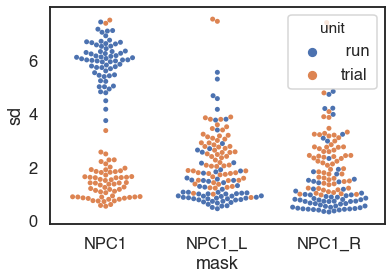

In [784]:
sns.swarmplot('mask', 'sd', 'unit', data=tmp['sd'].stack([0, 1]).to_frame('sd').reset_index())

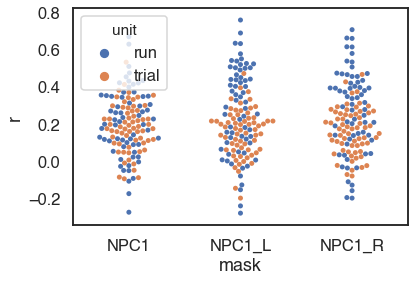

In [711]:
sns.swarmplot('mask', 'r', 'unit', data=tmp['r'].stack([0, 1]).to_frame('r').reset_index())

/Users/gdehol/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


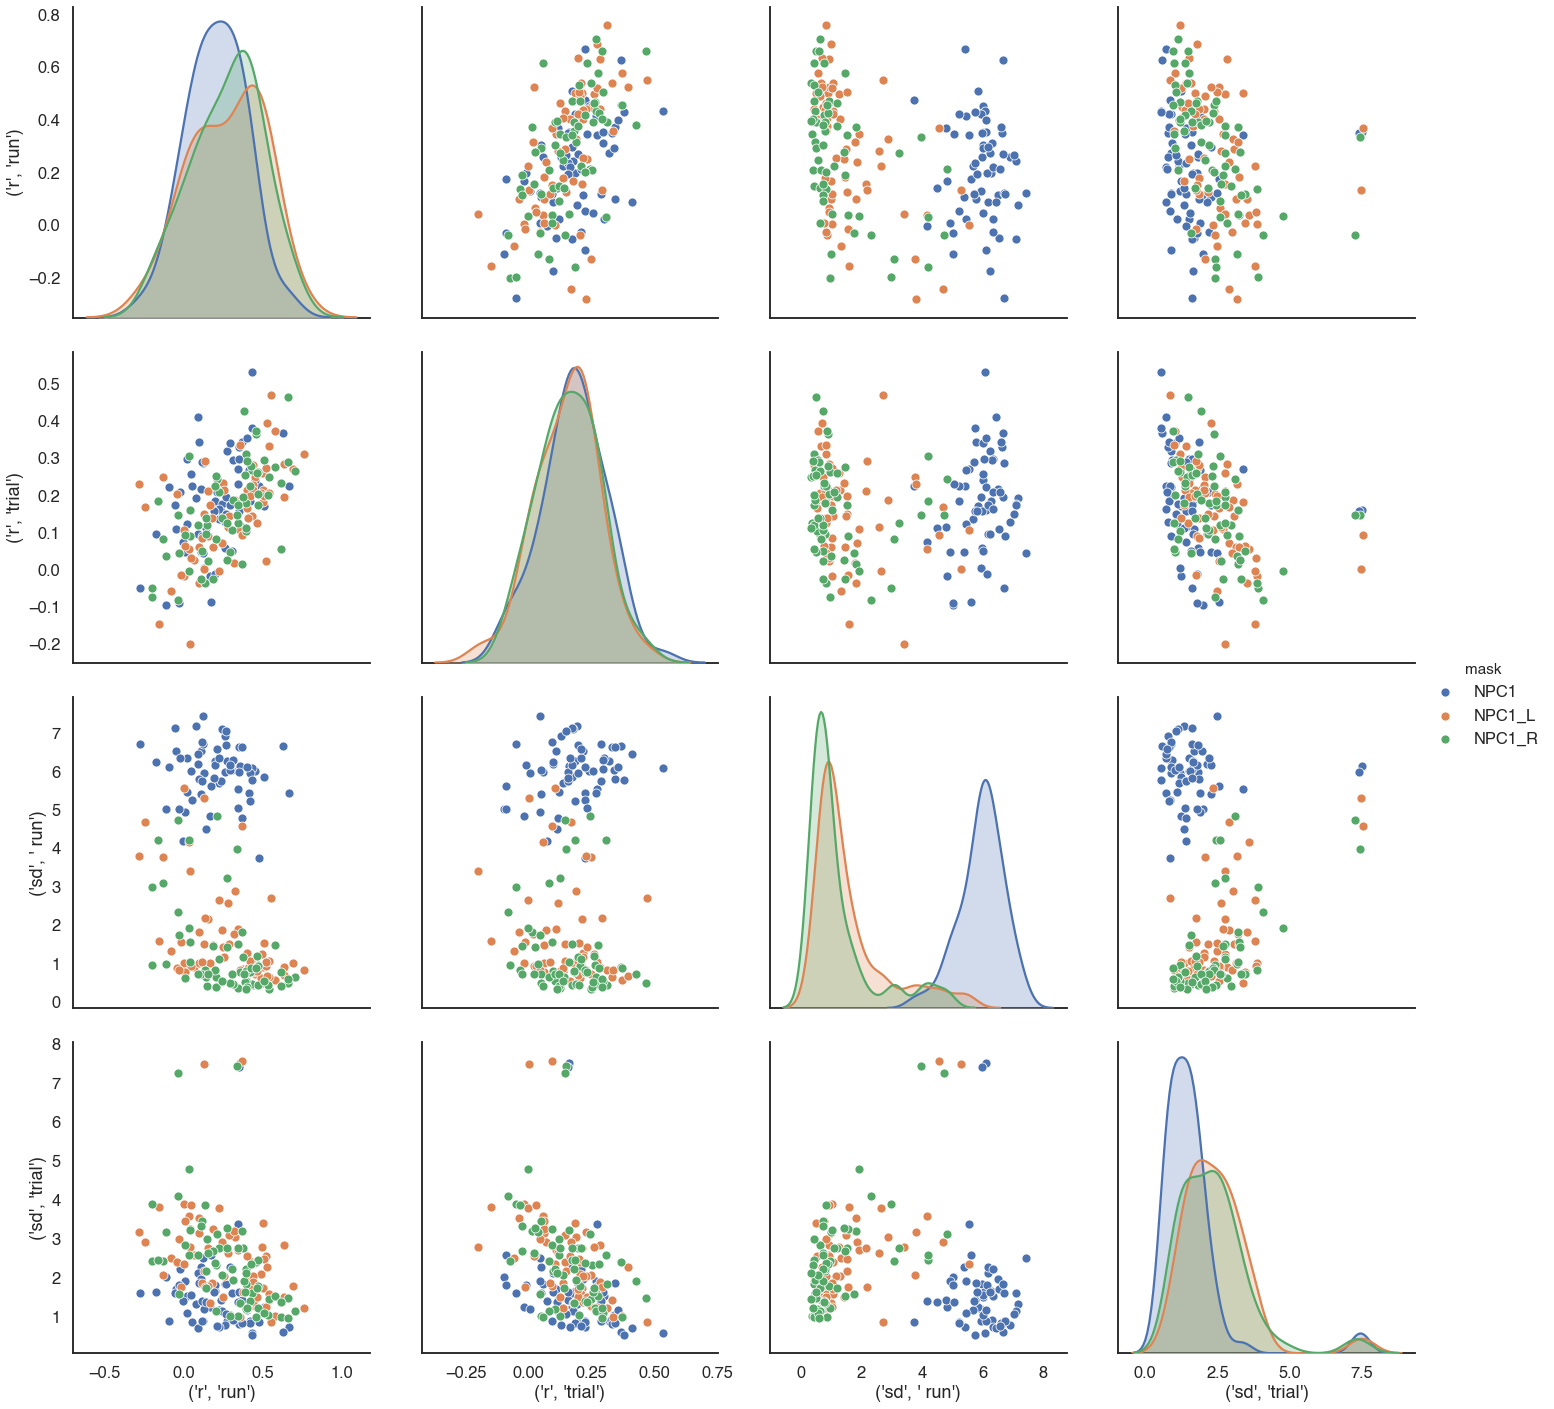

In [712]:
sns.pairplot(tmp.stack("mask").reset_index('mask'), hue='mask', size=5)

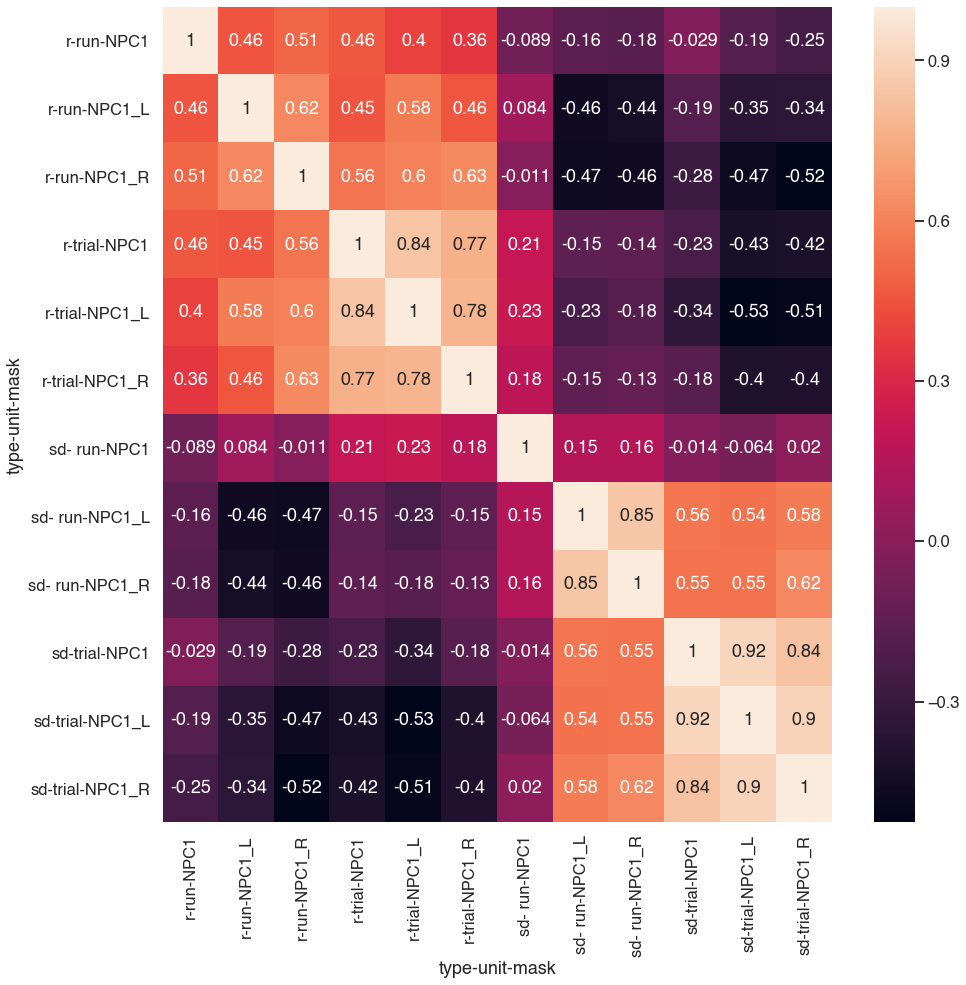

In [713]:
sns.heatmap(tmp.corr(), annot=True)

plt.gcf().set_size_inches((15, 15))

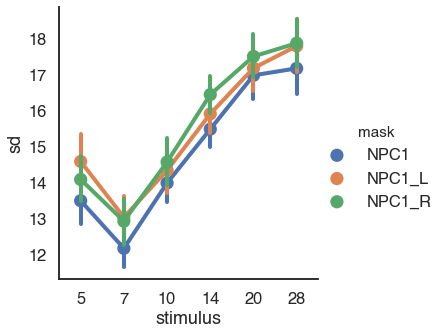

In [714]:
tmp = pdf[('pars', 'map')].groupby(['subject', 'mask', 'stimulus']).mean().to_frame('sd')

sns.catplot('stimulus', 'sd', 'mask', tmp.reset_index(), kind='point')

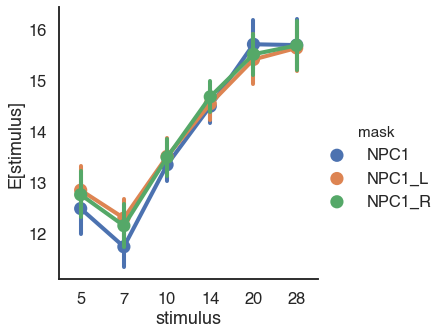

In [715]:
tmp = pdf[('pars', 'E[stimulus]')].groupby(['subject', 'mask', 'stimulus']).mean().to_frame('E[stimulus]')

sns.catplot('stimulus', 'E[stimulus]', 'mask', tmp.reset_index(), kind='point')

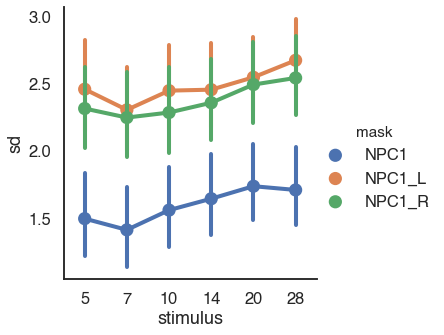

In [716]:
tmp = pdf[('pars', 'sd')].groupby(['subject', 'mask', 'stimulus']).mean().to_frame('sd')

sns.catplot('stimulus', 'sd', 'mask', tmp.reset_index(), kind='point')

In [717]:
pdf[('pars', 'error')] = (pdf[('pars', 'E[stimulus]')] - pdf.index.get_level_values('stimulus')).abs()

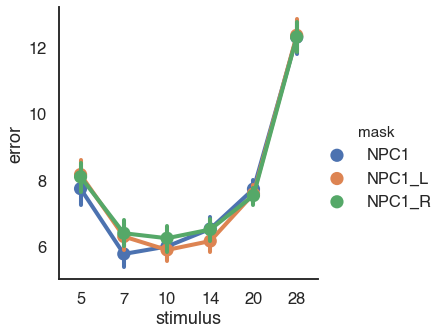

In [718]:
tmp = pdf[('pars', 'error')].groupby(['subject', 'mask', 'stimulus']).mean().to_frame('error')

sns.catplot('stimulus', 'error', 'mask', tmp.reset_index(), kind='point')

/Users/gdehol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


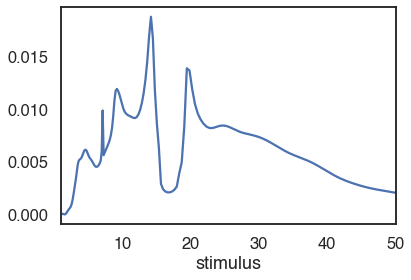

In [798]:

# pdf.loc[34, 'pdf'].mean().plot()
pdf.loc[9, 'pdf'].mean().plot()

pdf                                \
stimulus                                1.0      1.02      1.04     1.061   
run mask   stimulus log(stimulus)                                           
1   NPC1_L 5        1.609438       0.006389  0.006390  0.006387  0.006385   
                    1.609438       0.069089  0.069784  0.070391  0.070943   
                    1.609438       0.329564  0.336968  0.344159  0.351076   
                    1.609438       0.025839  0.025867  0.025861  0.025839   
                    1.609438       1.000000  0.934381  0.873707  0.817772   
...                                     ...       ...       ...       ...   
6   NPC1_R 28       3.332205       0.241232  0.246651  0.252008  0.257323   
                    3.332205       0.501850  0.496973  0.491964  0.487004   
                    3.332205       0.032512  0.032572  0.032619  0.032643   
                    3.332205       0.016069  0.016440  0.016797  0.017147   
                    3.332205       0.084515  0.086298  0.088000  0.089604   

                                                                           \
stimulus                              1.082     1.103     1.125     1.148   
run mask   stimulus log(stimulus)                                           
1   NPC1_L 5        1.609438       0.006381  0.006377  0.006374  0.006366   
                    1.609438       0.071404  0.071806  0.072149  0.072413   
                    1.609438       0.357694  0.364082  0.370222  0.376098   
                    1.609438       0.025788  0.025722  0.025631  0.025522   
                    1.609438       0.766259  0.718429  0.674407  0.633702   
...                                     ...       ...       ...       ...   
6   NPC1_R 28       3.332205       0.262559  0.267737  0.272818  0.277860   
                    3.332205       0.482036  0.477060  0.472078  0.467148   
                    3.332205       0.032655  0.032643  0.032627  0.032595   
                    3.332205       0.017488  0.017813  0.018131  0.018432   
                    3.332205       0.091104  0.092528  0.093836  0.095058   

                                                       ...       pars  \
stimulus                               1.17     1.194  ...        map   
run mask   stimulus log(stimulus)                      ...              
1   NPC1_L 5        1.609438       0.006361  0.006358  ...   7.282681   
                    1.609438       0.072626  0.072777  ...   7.282681   
                    1.609438       0.381788  0.387185  ...   6.865603   
                    1.609438       0.025398  0.025265  ...   7.140913   
                    1.609438       0.596180  0.561429  ...   1.000000   
...                                     ...       ...  ...        ...   
6   NPC1_R 28       3.332205       0.282856  0.287731  ...  13.395377   
                    3.332205       0.462213  0.457331  ...   7.282681   
                    3.332205       0.032548  0.032492  ...  19.082296   
                    3.332205       0.018725  0.019003  ...   7.427263   
                    3.332205       0.096143  0.097169  ...  19.461138   

                                                                           \
stimulus                           log(map)        sd     lower     upper   
run mask   stimulus log(stimulus)                                           
1   NPC1_L 5        1.609438       1.985499  5.016976  0.294876  3.774414   
                    1.609438       1.985499  7.752175  0.098292  3.754756   
                    1.609438       1.926524  7.952109  0.098292  3.794073   
                    1.609438       1.965841  6.999851  0.098292  3.695781   
                    1.609438       0.000000  7.175525  0.019658  3.577830   
...                                     ...       ...       ...       ...   
6   NPC1_R 28       3.332205       2.594910  8.110369  0.157267  3.695781   
                    3.332205       1.985499  8.430890  0.058975  3.735097   
            